# Chapter 7

## Raster Data

In [8]:
# Downloading the data, if not yet downloaded

import wget
import os

if not os.path.exists("data.zip"):
    url = 'http://data.geo.admin.ch/ch.swisstopo.images-landsat25/data.zip'
    wget.download(url,bar=None)
else:
    print("ok. data already downloaded.")

ok. data already downloaded.


In [9]:
# unzip the data if not yet unzipped

import zipfile

if not os.path.exists("landsat"):
    zip_ref = zipfile.ZipFile("data.zip", 'r')
    zip_ref.extractall("landsat")
    zip_ref.close()
else:
    print("ok. data already unzipped.")

ok. data already unzipped.


In [13]:
# Now we have the tif file "landsat/LandsatMos25.tif" extracted

import rasterio

ds = rasterio.open('landsat/LandsatMos25.tif', 'r')

In [14]:
print(ds.name)
print(ds.count) # number of raster bands, in our case 3 for r,g,b
print(ds.width, ds.height)

landsat/LandsatMos25.tif
3
16200 11040


In [21]:
ds.dtypes

('uint8', 'uint8', 'uint8')

In [28]:
print(ds.crs)

None


In [42]:
print(ds.bounds)

BoundingBox(left=460000.0, bottom=44000.0, right=865000.0, top=320000.0)


In [29]:
print(ds.transform)  # affine transformation pixel to crs+

| 25.00, 0.00, 460000.00|
| 0.00,-25.00, 320000.00|
| 0.00, 0.00, 1.00|


In [40]:
from rasterio.crs import CRS

ds = rasterio.open('landsat/LandsatMos25.tif', 'r+')
crs = CRS.from_epsg(21781)
ds.crs = crs
print(ds.crs)

EPSG:21781


In [26]:
ds.transform * (0, 0)    # Pixel to CRS

(460000.0, 320000.0)

In [43]:
~ds.transform # inverse affine transformation
~ds.transform * (0,0) # CRS to Pixel
px, py = ~ds.transform * (612073, 267991)
print(px,py)

6082.920000000002 2080.3600000000006


In [46]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [44]:
r = ds.read(1)
g = ds.read(2)
b = ds.read(3)

In [47]:
rgb = np.dstack((r,g,b))  # stack r,g,b so we can display it...

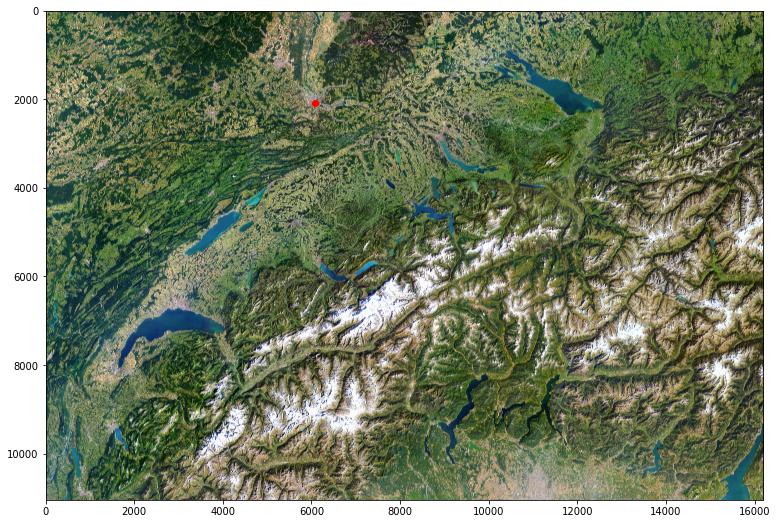

In [50]:
fig, ax = plt.subplots(figsize=(15,9))
ax.imshow(rgb, interpolation='bilinear')
ax.plot(px,py, 'ro'); 

plt.savefig("landsat.jpg")

## Vector Data

We're downloading earthquake data from USGS:
https://earthquake.usgs.gov/earthquakes/feed/v1.0/geojson.php

This data is updated every minute

* 2.5_week.geojson: All earthquakes > 2.5 from the last week
* 2.5_month.geojson: All earthquakes with a magnitude > 2.5 from the last month

We're looking at the data from last week

In [10]:
import requests

url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson"
#url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_month.geojson"

data = requests.get(url)
file = open("earthquakes.geojson","wb")
file.write(data.content)
file.close()

Now we use GeoPandas to load the dataset

Let's simplify the output and only take most important rows

In [30]:
eq = eq_gdf[["time","mag", "place","geometry"]].copy()
eq.head()

,time,mag,place,geometry
0,1558856474044,8.00,"75km SSE of Lagunas, Peru",POINT Z (-75.2975 -5.796 109.88)
1,1558854727234,5.00,"223km NW of Tanahmerah, Indonesia",POINT Z (139.0374 -4.4931 63.76)
2,1558849513920,2.71,"50km WSW of Rincon, Puerto Rico",POINT Z (-67.71680000000001 18.2401 5)
3,1558849079735,4.80,"90km SSE of Abepura, Indonesia",POINT Z (140.875 -3.4008 34.29)
4,1558847350626,4.70,"17km WSW of Bankura, India",POINT Z (86.8956 23.2132 10)


Look at the histogramm:

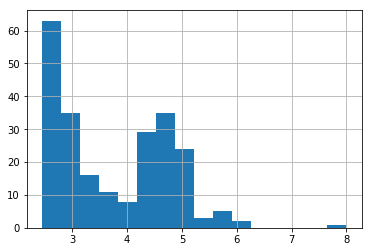

In [31]:
eq.mag.hist(bins=16);

Timestamps in UTC are not really human readable...
Let's convert them

In [32]:
from datetime import datetime, timezone

data = []
for row in range(0,len(eq)):
    time = eq.iloc[row].time
    t = str(datetime.fromtimestamp(time/1000.0, timezone.utc))
    data.append(t)
    
eq["time_utc"] = data
eq.head()

,time,mag,place,geometry,time_utc
0,1558856474044,8.00,"75km SSE of Lagunas, Peru",POINT Z (-75.2975 -5.796 109.88),2019-05-26 07:41:14.044000+00:00
1,1558854727234,5.00,"223km NW of Tanahmerah, Indonesia",POINT Z (139.0374 -4.4931 63.76),2019-05-26 07:12:07.234000+00:00
2,1558849513920,2.71,"50km WSW of Rincon, Puerto Rico",POINT Z (-67.71680000000001 18.2401 5),2019-05-26 05:45:13.920000+00:00
3,1558849079735,4.80,"90km SSE of Abepura, Indonesia",POINT Z (140.875 -3.4008 34.29),2019-05-26 05:37:59.735000+00:00
4,1558847350626,4.70,"17km WSW of Bankura, India",POINT Z (86.8956 23.2132 10),2019-05-26 05:09:10.626000+00:00


In [33]:
eq = eq.drop(['time'], axis=1)

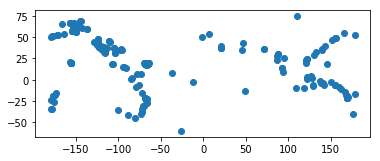

In [34]:
eq.plot();

Open Natural Earth Dataset with all Polygons of all countries

In [35]:
gdfAdmin0 = gpd.read_file("data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", encoding="utf-8")
gdfAdmin0.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,인도네시아,Indonesië,Indonezja,Indonésia,Индонезия,Indonesien,Endonezya,Indonesia,印度尼西亚,(POLYGON ((117.7036079039552 4.163414542001791...
1,Admin-0 country,5,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,말레이시아,Maleisië,Malezja,Malásia,Малайзия,Malaysia,Malezya,Malaysia,马来西亚,(POLYGON ((117.7036079039552 4.163414542001791...
2,Admin-0 country,6,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,칠레,Chili,Chile,Chile,Чили,Chile,Şili,Chile,智利,(POLYGON ((-69.51008875199994 -17.506588197999...
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,볼리비아,Bolivia,Boliwia,Bolívia,Боливия,Bolivia,Bolivya,Bolivia,玻利維亞,POLYGON ((-69.51008875199994 -17.5065881979999...
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,페루,Peru,Peru,Peru,Перу,Peru,Peru,Peru,秘鲁,(POLYGON ((-69.51008875199994 -17.506588197999...


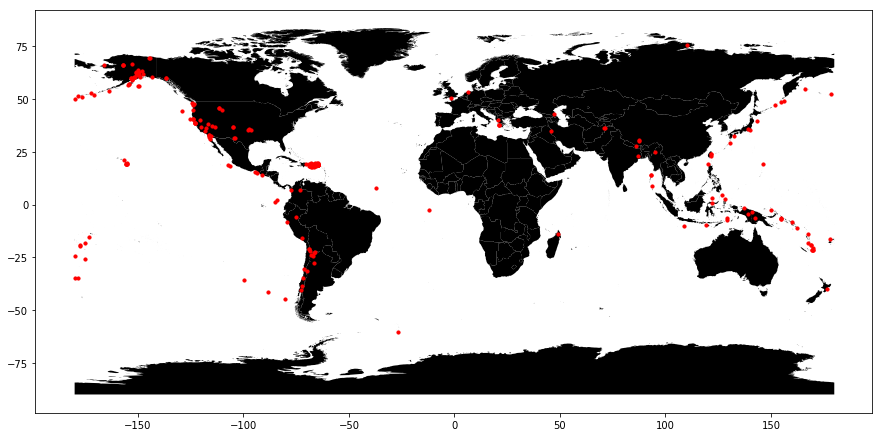

In [36]:
countries = gdfAdmin0.plot(figsize=(15,9), color="black")
eq.plot(ax=countries, color="red", markersize=10);

In [37]:
eq.sort_values(["mag"], ascending=False).head()

,mag,place,geometry,time_utc
0,8.0,"75km SSE of Lagunas, Peru",POINT Z (-75.2975 -5.796 109.88),2019-05-26 07:41:14.044000+00:00
220,6.2,"163km E of Tadine, New Caledonia",POINT Z (169.4581 -21.5843 20),2019-05-19 14:56:50.705000+00:00
94,6.1,"55km ENE of Amatignak Island, Alaska",POINT Z (-178.3306 51.3631 27.79),2019-05-23 08:45:18.547000+00:00
222,5.9,"175km E of Tadine, New Caledonia",POINT Z (169.564 -21.7298 10),2019-05-19 14:27:10.909000+00:00
87,5.7,"195km E of Tadine, New Caledonia",POINT Z (169.7702 -21.6089 10),2019-05-23 15:02:17.284000+00:00


### 4. More GeoPandas Fun

In [ ]:
import geopandas as gpd

gdfAdmin0 = gpd.read_file("data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", encoding="utf-8")
gdfAdmin0.head()

lt = gdfAdmin0[gdfAdmin0['NAME'] == "Lithuania"]
lt

In [ ]:
lt.plot()

In [ ]:
lt.crs

In [ ]:
lt_merc = lt.to_crs({'init': "epsg:3857"}) # reproject to web mercator
lt_merc.plot();

As an alternative we can always use Folium to display output. We can **directly** convert geopandas to geojson

Please note: we always have to use WGS84 (geopgraphic coordinates!) wghen using folium

In [ ]:
import folium

center = [54.716769, 25.287379] 
map_lt = folium.Map(center, zoom_start=5)   

folium.GeoJson(lt).add_to(map_lt)

map_lt

In [ ]:
import folium

center = [54.716769, 25.287379] 
map_lt = folium.Map(center, zoom_start=5)   

folium.GeoJson(lt,style_function=lambda feature: {
        'fillColor': 'green',   # you can also replace this with functions with feature as argument
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }).add_to(map_lt)

map_lt